# Content

In this part we are going to cover two important facts: 

1. analyse the missing values in order to detect structural fails during the webscraping 
2. bring value to the data troughout analytics and business insights.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import missingno as msno
from scipy.stats import chi2_contingency

In [2]:
data = pd.read_csv('../data/interim/amazon_shop_data_boxing_fighting_gloves_interim.csv')

In [3]:
data.head()

,title,brand,rating,ratings_number,price,prime_option,answers,first_date,sponsored_option,categories,position,page,category,position_c,subcategory,position_s
0,RDX Boxing Gloves Sparring and Muay Thai Maya ...,RDX,4.9,93,28.0,True,0,2020-11-06,True,['882 in Sports & Outdoors (See Top 100 in Spo...,0,1,Sports & Outdoors,882.0,Boxing Training Gloves,3.0
1,XN8 Boxing Gloves for Training Punch bag - MMA...,Xn8 Sports,4.6,306,23.0,True,5,2020-07-21,True,"['3,900 in Sports & Outdoors (See Top 100 in S...",1,1,Sports & Outdoors,3900.0,Boxing Gloves,21.0
2,"RDX MMA Gloves Grappling Sparring, Pre-Curved ...",RDX,4.9,13,22.0,True,0,2020-11-13,True,"['4,381 in Sports & Outdoors (See Top 100 in S...",2,1,Sports & Outdoors,4381.0,Boxing Gloves,25.0
3,RDX Boxing Gloves for Training Muay Thai Maya ...,RDX,4.7,1631,31.0,True,28,2018-10-05,True,"['2,252 in Sports & Outdoors (See Top 100 in S...",3,1,Sports & Outdoors,2252.0,Boxing Training Gloves,7.0
4,EVO Boxing Gloves with Hand Wraps For Men and ...,EVO Fitness,4.6,619,21.0,True,12,2014-02-06,False,['570 in Sports & Outdoors (See Top 100 in Spo...,4,1,Sports & Outdoors,570.0,Boxing Training Gloves,2.0


# Missing values

We will use the missingno package to take an overview about missing values. 

<AxesSubplot:>

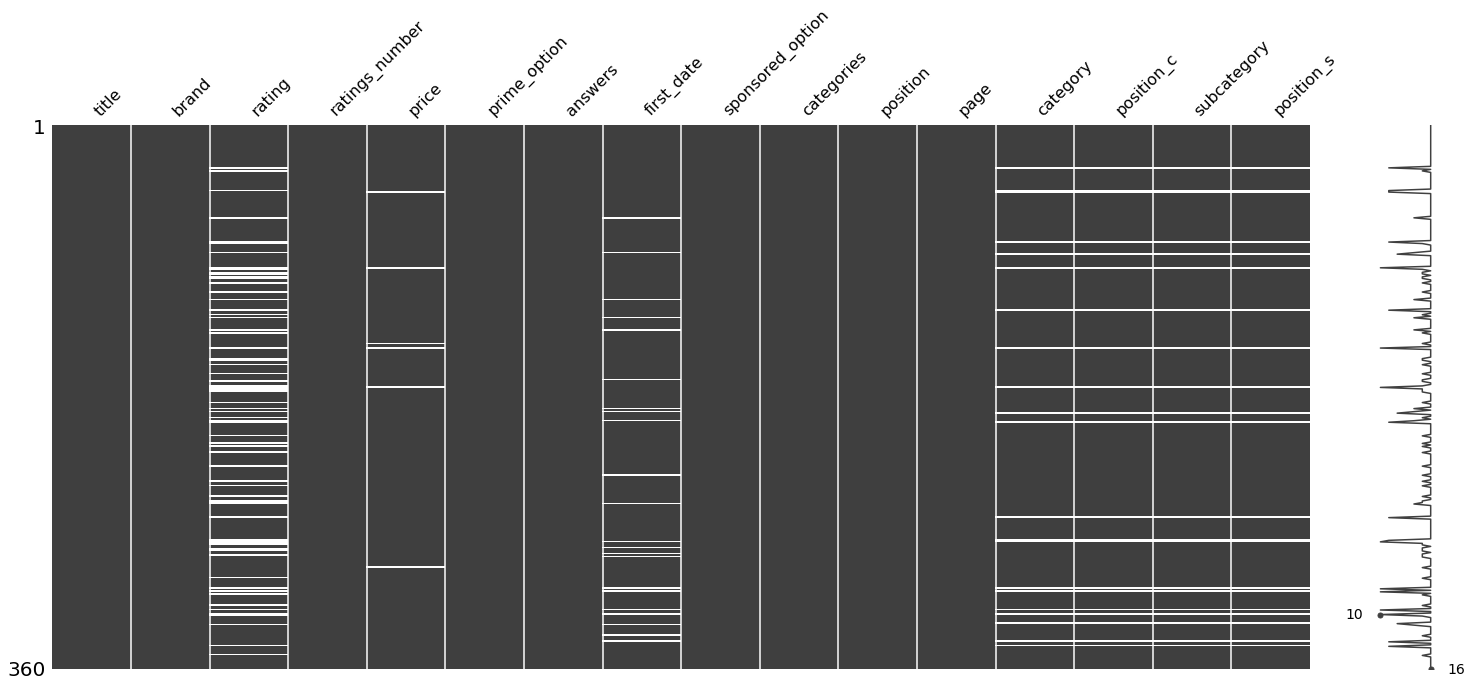

In [4]:
msno.matrix(data)

In this figure, we can see a dataset representation where each row represents a row of the dataset. If the value of some row is missing, it is white-colored, and else, it is black-colored. 

- **rating has the highest rate of missing values**. Also, those missing values seem independent from the missing values of the other columns. It could happen because the sellers do not show the product rate to customers or have not achieved ratings yet.

- **missing values in the category features are correlated**. The four columns present missing values simultaneously, and they seem uncorrelated with the other columns' missing values.

- **first_date has the second rate of missing values**. The missing values seem uncorrelated with the missing values of the other columns.

In overview, the structure of the missing values does not support the existence of a structural error during the data collection because the seller preferences can explain them.

We can check our insights with the nullity heatmap. The coefficients measure the nullity correlation. -1 means that if one feature appears, the other does not, 0 means no correlation between appearances, and one means that if one feature appears, the other also does.

<AxesSubplot:>

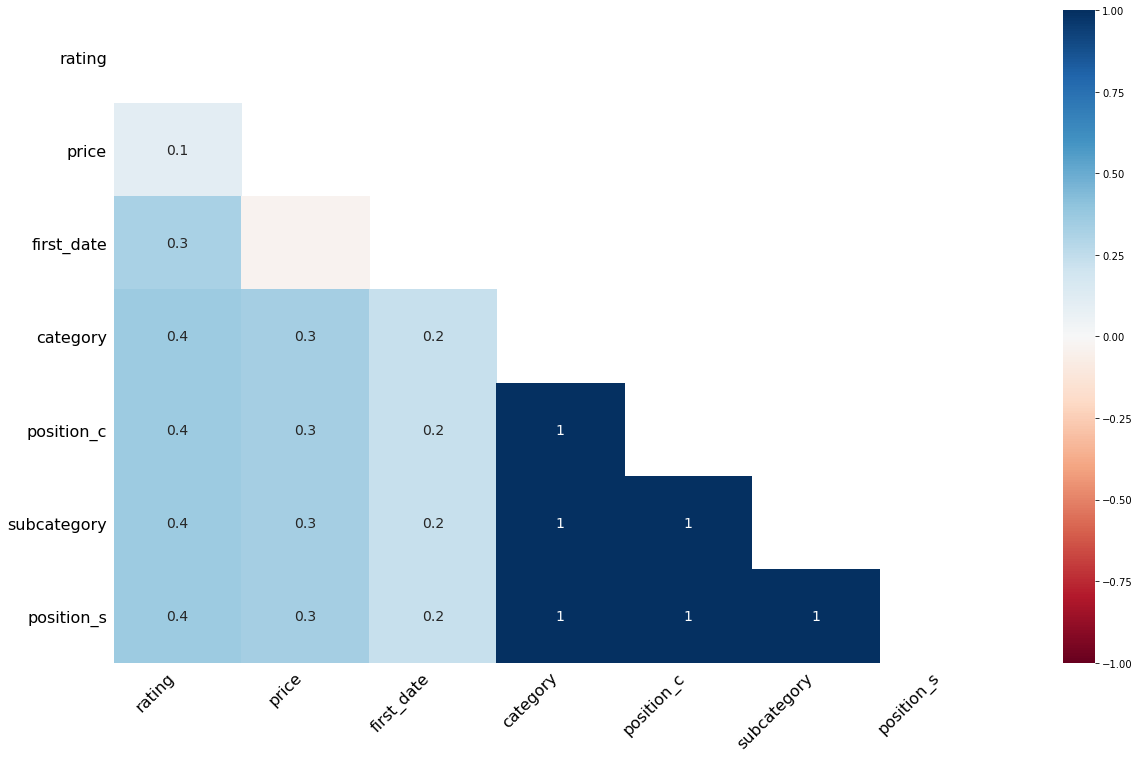

In [5]:
msno.heatmap(data)

# 1. General insights about the market shop

This section provides some visualizations to know more about the product environment: categories where the products are classified, target clients, and competitive environment.

## 1.1 Which categories have the companies chosen to sell their product in the key words "boxing fighting gloves"?

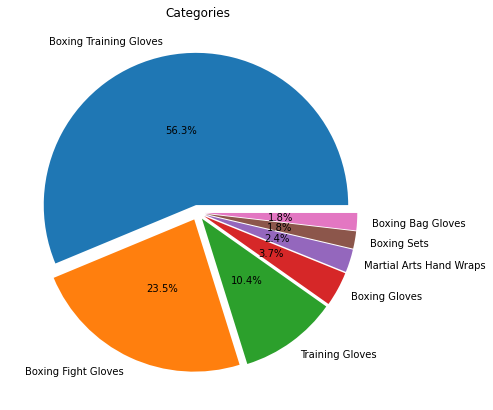

In [6]:
prod_categories = data['subcategory'].value_counts()[data['subcategory'].value_counts()>5]

plt.subplots(figsize=[10,7])
plt.pie(x=prod_categories, autopct="%.1f%%",normalize=True, explode=[0.05]*len(prod_categories),
        labels=prod_categories.index.tolist(), pctdistance=0.5)
plt.title('Categories')
plt.savefig('figures/categories.png')
plt.show()

## 1.2 Are the products segmented for different targets and which are these segments?

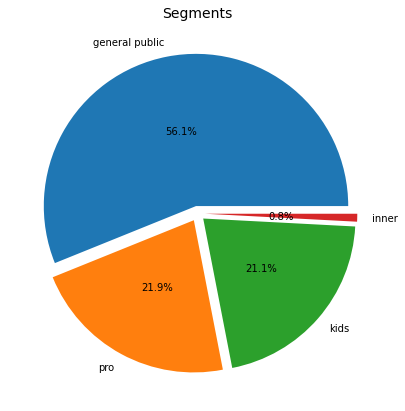

In [7]:
pie, ax = plt.subplots(figsize=[10,7])
min_n=6

target_values = data['title'].apply(lambda x: 'kids' if 'kids' in x.lower() else
                  ('pro' if 'pro' in x.lower() else
                   ('inner' if 'inner' in x.lower() else 'general public'))).value_counts()

cat_names = target_values.index

plt.pie(x=target_values, autopct="%.1f%%", explode=[0.05]*len(target_values), labels=cat_names, pctdistance=0.5)
plt.title("Segments", fontsize=14);
plt.savefig('figures/segments.png')
plt.show()

## 1.3 Which are the main brands selling boxing gloves on Amazon, and which "market share" they have?

We can compute which brands appear more than the 90th percentile times to get the leading brands.

In [8]:
np.percentile(data['brand'].value_counts(), 90)

6.799999999999997

['RDX', 'Valour Strike', 'EVO Fitness', 'Starpro', 'VELO', 'BOOM Prime', 'Farabi Sports', 'Xn8 Sports', '3X Professional Choice', 'ONEX', 'Venum', 'Rex Sports', 'other'] [68, 23, 20, 14, 12, 11, 8, 8, 8, 8, 8, 7, 172]


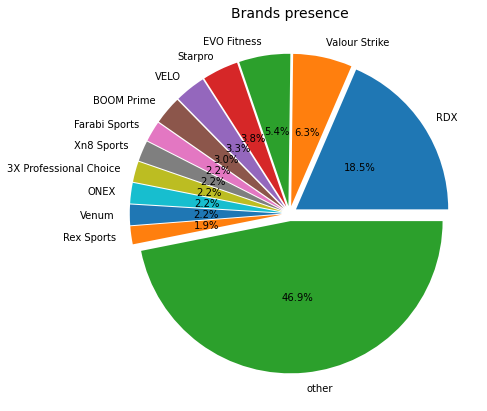

In [9]:
min_n=7
pie, ax = plt.subplots(figsize=[10,7])

notable_brands = data['brand'].value_counts()[data['brand'].value_counts()>=min_n].index.tolist()
notable_brands.append('other')

brand_values = data['brand'].value_counts()[data['brand'].value_counts()>=min_n].tolist()
brand_values.append(pd.Series(data['brand'].value_counts()[data['brand'].value_counts()<=min_n].sum())[0])

print(notable_brands, brand_values)

plt.pie(x=brand_values, autopct="%.1f%%", explode=[0.05]*len(notable_brands), labels=notable_brands, pctdistance=0.5)
plt.title("Brands presence", fontsize=14);
# pie.savefig("DeliveryPieChart.png")
plt.savefig('figures/main_brands.png')
plt.show()

We can see that it is a fragmented shop with just one leading brand in the search result: RDX

# 2. Amazon Prime option analysis

## 2.1 How many brands offer the Amazon Prime option?

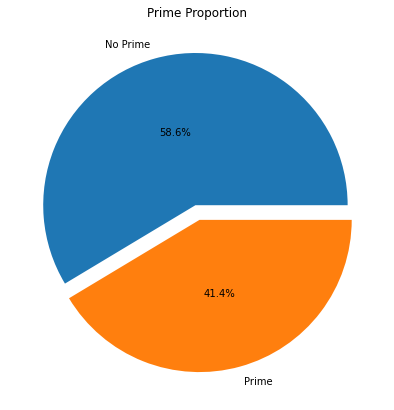

In [10]:
prime_number = np.array(data['prime_option'].value_counts())
total = data.shape[0]

proportions = prime_number/total
plt.subplots(figsize=[10,7])
plt.pie(x=proportions, autopct="%.1f%%", explode=[0.05]*2,
        labels=['No Prime', 'Prime'], pctdistance=0.5)
plt.title('Prime Proportion')
plt.savefig('figures/prime-prop.png')
plt.show()

We can see that, approximately, the half part of the sellers offer the prime option.

## 2.2 Is the price related with the prime option?

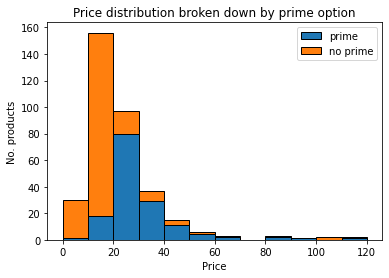

In [20]:
plt.hist([data[data['prime_option']]['price'], data[~data['prime_option']]['price']],
        bins=np.array(range(13))*10, stacked=True, histtype='barstacked', ec='black')
plt.legend(['prime', 'no prime'])
plt.title('Price distribution broken down by prime option')
plt.xlabel('Price')
plt.ylabel('No. products')
plt.savefig('figures/price-prime.png')

We can see that the higher price, the more proportion of prime option products we find. We notice that between 0 and 20 pounds, it is usual to not find prime options, and between 20 and infinite, it is usually the opposite.

In [12]:
pd.crosstab(pd.cut(data['price'], bins=np.array([0,20,np.inf])), data['prime_option'])

prime_option,False,True
price,,
"(0.0, 20.0]",167,30
"(20.0, inf]",38,119


We will check the dependence with a chi square test.

In [13]:
lamb, p, df, _ = chi2_contingency(pd.crosstab(pd.cut(data['price'], bins=np.array([0,20,np.inf])),
                                              data['prime_option']))
print('p-value: ', p, '| statistic: ', lamb)

p-value:  6.704862503095976e-30 | statistic:  129.02265714301248


And we should reject the hypothesis of independence and accept that the number of prime options depends on the product's price.

## 2.3 Has the position in the category rank an impact on the number of prime products?

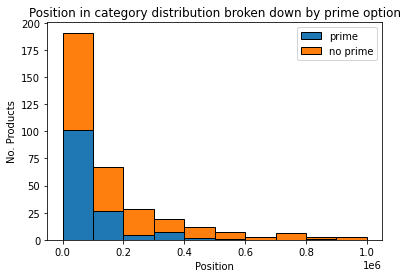

In [19]:
plt.hist([data[data['prime_option']]['position_c'], data[~data['prime_option']]['position_c']],
        bins=np.array(range(11))*100000, stacked=True, histtype='barstacked', ec='black')
plt.legend(['prime', 'no prime'])
plt.title('Position in category distribution broken down by prime option')
plt.xlabel('Position')
plt.ylabel('No. Products')
plt.savefig('figures/position-prime.png')

We can see that the higher the category rank, the less proportion of prime option products we find.

## 2.4 Do the sponsored products sell more in prime option than no sponsored?

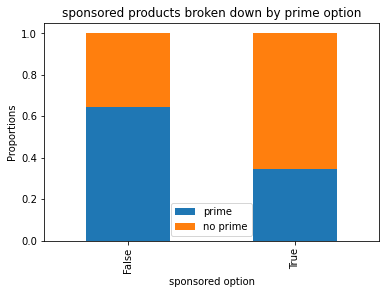

In [21]:
pd.crosstab(data['sponsored_option'], data['prime_option'], normalize='index').plot(kind='bar', stacked=True)
plt.legend(['prime', 'no prime'])
plt.xlabel('sponsored option')
plt.ylabel('Proportions')
plt.title('sponsored products broken down by prime option')
plt.savefig('figures/sponsored-prime.png')

We can see that sponsored products are more likely to offer the prime option. We can check our assumption throughout a chi-square test of independence.

In [16]:
lamb, p, df, _ = chi2_contingency(pd.crosstab(data['sponsored_option'], data['prime_option']))
print('p-value: ', p, '| statistic: ', lamb)

p-value:  7.91055126804541e-06 | statistic:  19.959365755908266


The results show that we should reject the independence, which means that the number of prime options depends on the presence of the sponsored option.

## 2.5 Has the product score an impact on the number of prime products?

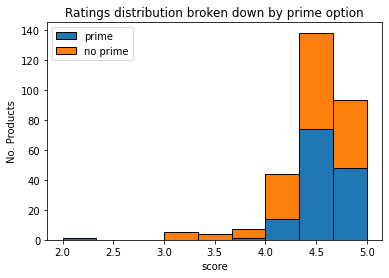

In [18]:
plt.hist([data[data['prime_option']]['rating'], data[~data['prime_option']]['rating']],
        stacked=True, histtype='barstacked', ec='black', bins=9)
plt.legend(['prime', 'no prime'])
plt.title('Ratings distribution broken down by prime option')
plt.xlabel('score')
plt.ylabel('No. Products')
plt.savefig('figures/rating-prime.png')

We can see that the products with low scores usually offer their products with the prime option. Probably it is due to they are trying to be competitive against the products with the best scores but without the prime option.

# 3. Conclussion

We can conclude some important facts such as:

1. There is no evidence of any structural error during the web scraping process.
2. The search "boxing fighting gloves" drives the customer into a shop which is:
- fragmented from the competition point of view.
- focused on three target clients: general public (56%), kids (21%), and professional (21%)
- based on three main Amazon subcategories: Boxing Training Gloves (56%), Boxing Fighting Gloves (23%), and Training Gloves (10%).
3. We found four features that can explain the presence of the prime option and can be used to classify products in prime and not prime option:
- Product price (integer)
- Category rank position (integer)
- Sponsored Product (bool)
- Product score (float, 1 decimal)